In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/ludo/ownCloud/Programmes/julia/biomaths_julia_www"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using DifferentialEquations, Plots, DataFrames

# paramètres
r = 5.0      # natalité
K = 10.0     # mortalité
α = 1.0      # taux max de prédation
h = 0.5      # constante de demi-saturation

ϵ = 0.01     # timescale
n = 5.0      # gain à la prédation
m = 3.0      # moralité


par_tord_ois = [r, K, α, h, ϵ, n, m] 

# temps d'intégration
tspan = (0.0, 400.0)
tstep = 0.02

# conditions initiales
x0 = 1.0    # tordeuses
y0 = 2.5    # oiseaux
etat0 = [x0, y0]

2-element Vector{Float64}:
 1.0
 2.5

In [3]:
function tord_ois(u, param, t)
    r, K, α, h, ϵ, n, m = param
    x = u[1]
    y = u[2]
    dx = r*x*(1 - x/K) - α*x^2/(h^2 + x^2) * y
    dy = ϵ*(n*α*x^2/(h^2 + x^2) * y - m * y)
    [dx, dy]
end

tord_ois (generic function with 1 method)

In [4]:
prob_tord_ois = ODEProblem(tord_ois, 
                           etat0, 
                           tspan, 
                           par_tord_ois, 
                           saveat = tstep)

sol_tord_ois = solve(prob_tord_ois, reltol = 1e-6)

sol_tord_ois = DataFrame(sol_tord_ois)
rename!(sol_tord_ois, :timestamp => :time, :value1 => :x, :value2 => :y)

Row,time,x,y
,Float64,Float64,Float64
1,0.0,1.0,2.5
2,0.02,1.05164,2.50052
3,0.04,1.10671,2.50108
4,0.06,1.16549,2.50167
5,0.08,1.22822,2.5023
6,0.1,1.29519,2.50296
7,0.12,1.36667,2.50365
8,0.14,1.44293,2.50437
9,0.16,1.52427,2.50512


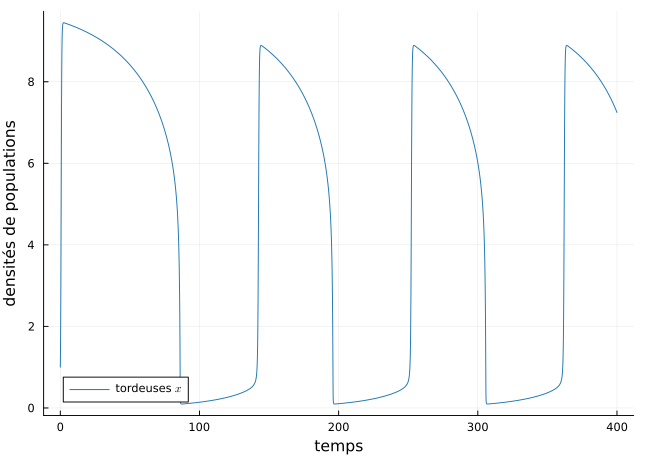

In [5]:
#| output: true
# color definitions
mygreen = palette(:tab10)[3]
myorange = palette(:tab10)[2]
myblue = palette(:tab10)[1]
myred = palette(:tab10)[4]

plot(sol_tord_ois.time, sol_tord_ois.x,
     color = myblue,
     label = "tordeuses \$x\$",
     xlabel = "temps",
     ylabel = "densités de populations")